<a href="https://colab.research.google.com/github/NaRuecker/Final-Capstone/blob/master/Final_Capstone_NLP_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
!ls "/content/drive/My Drive/FinalCapNLP"

 2014-03-09_USM_Klingler.pdf
 all_UStweets_cleaned.csv
'Carbon balance 2014-01.xlsx'
'Colab Notebooks'
'Copy of Copy of Schedule for Paridhi Gautam_PP SG CE CT JA LB NR.xlsx.gsheet'
'Copy of Copy of Schedule for Paridhi Gautam_PP SG CE CT JA LB.xlsx'
'Copy of Networking Assignment Doc - Copy.gdoc'
'day 14 data II.txt'
'Ehrt&Schnappinger Lab meeting schedule winter-spring 2015.xlsx'
 FinalCapNLP
'Fumarase poster for Career fair.pptx'
'Glencore OCDI Locations vs Incident Data Tabs.xlsx'
 IMG_5677.JPG
 IMG_5689.JPG
 IMG_5696.JPG
 IMG_7113.JPG
'IMP Retreat Poster.pptx'
 Info_timesaver.gslides
 Lecture01_02_03.ppt
 mlp1.pdf
'Nadine Ruecker Thinkful Data Science Graduate Plan 57067.gsheet'
 NR_CV_Dekra.gslides
 NR_CV_Dekra.pptx
 NR_CV.pptx
'Research Informatics Specialist DEKRA NA 17.10.docx'
'Ruecker Quote.pdf'
 vw.pdf
 weihnk.pdf


In [0]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import time
import matplotlib.pyplot as plt
%matplotlib inline

import glob, os
from collections import Counter
import re

# Plotting
#!pip install plotnine
#from plotnine import *
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')

# Feature engineering
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Modeling
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import ensemble
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

# Similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from __future__ import print_function
from scipy.spatial.distance import cdist

# Prepare data

In [0]:
# Load the current tweet data

df=pd.read_csv('/content/drive/My Drive/FinalCapNLP/USonly_tweet_data.csv')
General=df['Cat'].str.split('y',n = 1, expand = True)
df['General']=General[0]+'y'
df.head()
df.shape

(164947, 8)

In [0]:
# For the NLP analysis, I will remove tweets that have the same content:
# These are duplicates, that might have been captured in different categories,
# but also retweets
# remove duplicates and retweets
df['tweet']=df['tweet'].astype(str)
df= df.drop_duplicates(subset='tweet')
print(df.shape)

# Remove NAs from the category
df=df.dropna(subset=['General'])
df.shape

(150624, 8)


(150464, 8)

In [0]:
# Removing special characters
df['tweetnew']=df['tweet'].str.replace(r'[^\w\s,]','') # this replaces common special characters
#Symbolstoremove=[ð,Ÿ,�]
df['tweetnew2']=df['tweetnew'].str.replace('[ðŸ�ê²½ìƒ©°¹•„¹¨íäœæ›å®¶ãä€è¦§â€¢ëŒ³žŽ³žŠ]','')

In [0]:
df.to_csv('all_UStweets_cleaned.csv',index=False)
file = drive.CreateFile() 
file.SetContentFile("all_UStweets_cleaned.csv")
file.Upload()
!ls "/content/drive/My Drive

ApiRequestError: ignored

In [0]:
df.head()

,Unnamed: 0,Cat,Year,Query,State,tweet,retweet,General,tweetnew,tweetnew2
0,0,HealthyFood,2013.0,apple,il,apple crates @virtuecider http://instagram.co...,NaN,Healthy,apple crates virtuecider httpinstagramcompXdf...,apple crates virtuecider httpinstagramcompXdf...
1,1,HealthyFood,2013.0,apple,fl,"Samsung outguns Apple in marketing, report say...",NaN,Healthy,"Samsung outguns Apple in marketing, report say...","Samsung outguns Apple in marketing, report say..."
2,2,HealthyFood,2013.0,apple,tx,Apple Makes Its Accounts More Secure http://b...,NaN,Healthy,Apple Makes Its Accounts More Secure httpbitl...,Apple Makes Its Accounts More Secure httpbitl...
3,3,HealthyFood,2013.0,apple,ut,@perezcommajamie I do use Zune!!! It's the pro...,NaN,Healthy,perezcommajamie I do use Zune Its the program ...,perezcommajamie I do use Zune Its the program ...
4,4,HealthyFood,2013.0,apple,ny,Very Nice Flavor â€” Drinking a Shock Top Hone...,NaN,Healthy,Very Nice Flavor â Drinking a Shock Top Honeyc...,Very Nice Flavor Drinking a Shock Top Honeycr...


In [0]:
# Split into training and test set
from sklearn.model_selection import train_test_split

X=df
Y=df['General']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
X_train=X_train.reset_index()
X_test=X_test.reset_index()
Y_train=Y_train.reset_index()
Y_test=Y_test.reset_index()
print(X_train.shape)
print(X_test.shape)

(112848, 11)
(37616, 11)


In [0]:
X_train.head()

,index,Unnamed: 0,Cat,Year,Query,State,tweet,retweet,General,tweetnew,tweetnew2
0,70020,70020,HealthyFood,2015.0,cranberry,pa,What if the earth isn't spinning just going so...,NaN,Healthy,What if the earth isnt spinning just going so ...,What if the earth isnt spinning just going so ...
1,29360,29360,HealthyFood,2014.0,beans,or,@dan_fincher thanks for the intrest in my stre...,NaN,Healthy,dan_fincher thanks for the intrest in my strea...,dan_fincher thanks for the intrest in my strea...
2,35355,35355,HealthyFood,2014.0,coconut,mn,Coconut Grove - THE LOVIN' SPOONFUL http://rd...,NaN,Healthy,Coconut Grove THE LOVIN SPOONFUL httprdotoWX...,Coconut Grove THE LOVIN SPOONFUL httprdotoWX...
3,3888,3888,HealthyFood,2013.0,cabbage,al,Skillet Cabbage!! âœ»áƒ¦Ï â‚¡áƒ¦âœ» Click on ...,NaN,Healthy,Skillet Cabbage âœáƒÏ âáƒâœ Click on the Foll...,Skillet Cabbage áÏ á Click on the Follow Me B...
4,163625,163625,UnhealthyFood,2017.0,soda,ca,"I don't blame you. I like soda, but I like fru...",NaN,Unhealthy,"I dont blame you I like soda, but I like fruit...","I dont blame you I like soda, but I like fruit..."


# tfidf-matrix

In [0]:
# Convert data to list
X_train_l=X_train['tweetnew2'].tolist()
print(len(X_train_l))
X_test_l=X_test['tweetnew2'].tolist()

#Initiate the vectorizer
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than 50% of all the paragraphs
                                min_df=3, # only use words that appear at least 4 times
                                stop_words='english', 
                                lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                                use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                                norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                                smooth_idf=True, #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                                ngram_range=(1,1) # only n-grams =1 word combinations
                            )

# Fit the vectorizer using the training set
train_tfidf=vectorizer.fit_transform(X_train_l)
print("Number of features: %d" % train_tfidf.get_shape()[1])
#Applying the vectorizer to the test data
test_tfidf=vectorizer.transform(X_test_l)

112848
Number of features: 21151


## LSA

In [0]:
#Our SVD data reducer. .
svd= TruncatedSVD(n_components=300)
lsa = make_pipeline(svd, Normalizer(copy=False))
train_lsa_features = lsa.fit_transform(train_tfidf)
print("Number of features after svd:", train_lsa_features.shape[1])

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

results=pd.DataFrame()
results['svd']=range(300)
results['variance']=svd.explained_variance_ratio_
results=results.sort_values('variance',ascending=False)
print(results.head())

# transform the test dataset
test_lsa_features = lsa.transform(test_tfidf)

Number of features after svd: 300
Percent variance captured by all components: 31.913681050132436
   svd  variance
1    1  0.003976
2    2  0.003675
3    3  0.003595
4    4  0.003292
5    5  0.003144


In [0]:
# Make a new df to store the new features
lsa_df=pd.DataFrame(data=train_lsa_features)
test_lsa_df=pd.DataFrame(data=test_lsa_features)

# Add columns names
n_lsa=lsa_df.shape[1]

columnsN=[]
for i in range(n_lsa):
    columnsN.append('lsa_'+str(i+1))


lsa_df.columns=columnsN
lsa_df['General']=Y_train.General
lsa_df['Cat']=X_train.Cat
lsa_df['Query']=X_train.Query
lsa_df['tweetnew2']=X_train.tweetnew2
lsa_df['Year']=X_train.Year
lsa_df['State']=X_train.State

print(lsa_df.shape)

# Add columns names for the test data frame
n_lsa=test_lsa_df.shape[1]

columnsN=[]
for i in range(n_lsa):
    columnsN.append('lsa_'+str(i+1))


test_lsa_df.columns=columnsN
test_lsa_df['General']=Y_test.General
test_lsa_df['Cat']=X_test.Cat
test_lsa_df['Query']=X_test.Query
test_lsa_df['tweetnew2']=X_test.tweetnew2
test_lsa_df['Year']=X_test.Year
test_lsa_df['State']=X_test.State

print(test_lsa_df.shape)


#expVar12=round((results.variance.iloc[0]+results.variance.iloc[1])*100,3)
#Title='Around '+ str(expVar12) +'% variance explained through lsa1 and lsa2'
#(ggplot(lsa_df)
# + geom_point(aes(x='lsa_1', y='lsa_2', color='General'))
# + labs(title=Title)
#)

(112848, 306)
(37616, 306)


In [0]:
lsa_df.to_csv('Train_lsa_df.csv')
file = drive.CreateFile() 
file.SetContentFile("Train_lsa_df.csv")
file.Upload()





In [0]:
!ls "/content/drive/My Drive"

 2014-03-09_USM_Klingler.pdf
 all_UStweets_cleaned.csv
'Carbon balance 2014-01.xlsx'
'Colab Notebooks'
'Copy of Copy of Schedule for Paridhi Gautam_PP SG CE CT JA LB NR.xlsx.gsheet'
'Copy of Copy of Schedule for Paridhi Gautam_PP SG CE CT JA LB.xlsx'
'Copy of Networking Assignment Doc - Copy.gdoc'
'day 14 data II.txt'
'Ehrt&Schnappinger Lab meeting schedule winter-spring 2015.xlsx'
 FinalCapNLP
'Fumarase poster for Career fair.pptx'
'Glencore OCDI Locations vs Incident Data Tabs.xlsx'
 IMG_5677.JPG
 IMG_5689.JPG
 IMG_5696.JPG
 IMG_7113.JPG
'IMP Retreat Poster.pptx'
 Info_timesaver.gslides
 Lecture01_02_03.ppt
 mlp1.pdf
'Nadine Ruecker Thinkful Data Science Graduate Plan 57067.gsheet'
 NR_CV_Dekra.gslides
 NR_CV_Dekra.pptx
 NR_CV.pptx
'Research Informatics Specialist DEKRA NA 17.10.docx'
'Ruecker Quote.pdf'
 Test_lsa.csv
'Train_lsa_df (1).csv'
 Train_lsa_df.csv
 vw.pdf
 weihnk.pdf


In [0]:
test_lsa_df.to_csv('Test_lsa.csv')
file = drive.CreateFile() 
file.SetContentFile('Test_lsa.csv')
file.Upload()
!ls "/content/drive/My Drive

In [0]:
lsa_df.to_csv('Train_lsa_df.csv')
test_lsa_df.to_csv('Test_lsa.csv')

In [0]:
from google.colab import files
files.download('Train_lsa_df.csv')
files.download('Test_lsa.csv')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 46756, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [0]:
# to export files to the google drive
!pip install -U -q PyDrive 

In [0]:
#expVar12=round((results.variance.iloc[0]+results.variance.iloc[1])*100,3)
#Title='Around '+ str(expVar12) +'% variance explained through lsa1 and lsa2'
#(ggplot(lsa_df)
# + geom_point(aes(x='lsa_1', y='lsa_2', color='Cat'))
# + labs(title=Title)
#)

In [0]:
# Exploring the first component 
lsa_df[['lsa_6','Query','tweetnew2','General']].sort_values(['lsa_6'], ascending=False).head(10)

,lsa_6,Query,tweetnew2,General
103695,0.604881,brussels sprouts,If you like Brussels Sprouts youll like this ...,Healthy
38308,0.543137,brussels sprouts,"None of us like brussels sprouts, but this see...",Healthy
34856,0.542776,brussels sprouts,Seahawks DE Michael Bennett on why quarterback...,Healthy
108624,0.542776,brussels sprouts,Seahawks DE Michael Bennett on why quarterback...,Healthy
28157,0.536809,brussels sprouts,Gardening and episode 310 of themmahour Anyon...,Healthy
60398,0.536702,brussels sprouts,liltang_ skin tastes like brussels sprouts,Healthy
40015,0.535607,brussels sprouts,Only 3 of Americans like Brussels sprouts Fact...,Healthy
60709,0.528672,brussels sprouts,"If you dont like brussels sprouts, youve never...",Healthy
3552,0.518917,papaya,I like my eyes httpstwittercomdrugsmediastatus...,Healthy
108395,0.518480,cookie,Brody act like he knows anything about basebal...,Unhealthy


## LDA

In [0]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

# But lets first focus on the 6 main categories
ntopics=300

lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

train_lda = lda.fit_transform(train_tfidf) 
print('TFIDF shape:',train_tfidf.shape)
print('paras_lda shape:',train_lda.shape)


# Number of words to look at for each topic.
#n_top_words = 20
#topwords=pd.DataFrame()
#topwords['LDA']=top_words(components_lda, n_top_words)

TFIDF shape: (112848, 21151)
paras_lda shape: (112848, 300)


In [0]:
# transform the test dataset
test_lda_features = lda.transform(test_tfidf)

# Make a new df to store the new features
lda_df=pd.DataFrame(data=train_lda)
test_lda_df=pd.DataFrame(data=test_lda_features)

## None negative matrix factorization

In [0]:
from sklearn.decomposition import NMF
ntopics=300
nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )

train_nmf = nmf.fit_transform(train_tfidf) 
print('TFIDF shape:',train_tfidf.shape)
print('paras_nmf shape:',train_nmf.shape)

# Make a new df to store the new features
nmf_df=pd.DataFrame(data=train_nmf)


# transform the test dataset
test_nmf_features = nmf.transform(test_tfidf)
test_nmf_df=pd.DataFrame(data=test_nmf_features)

TFIDF shape: (112848, 21151)
paras_nmf shape: (112848, 300)


# Predict Tweet category
## Functions

In [0]:
def runRFC_class(input_df, target, no_folds):
    start_time=time.time()
    param_grid= {'n_estimators': [50,100,200,500]}
    print('Random Forest')
    rand_forest_class = ensemble.RandomForestClassifier()
    CV_model = GridSearchCV(estimator=rand_forest_class, param_grid=param_grid, cv= 5)
    
    CV_model.fit(input_df, target)
    cvs = cross_val_score(CV_model, input_df, target, cv=no_folds) 
    print("Best parameters:", CV_model.best_params_) 
    #print('Feature Importance:{}',rand_forest_class.feature_importances_)
       
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy RFC: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()

    return(cvs)

In [0]:
def runKNN_class(input_df, target,no_folds):
    start_time=time.time()
    param_grid= {'n_neighbors': [ 3,5,7,10]}
    print('KNN')
    knn_w = neighbors.KNeighborsClassifier(weights='distance')
    CV_model = GridSearchCV(estimator=knn_w, param_grid=param_grid, cv= 5)
    CV_model.fit(input_df, target)
    
    cvs = cross_val_score(CV_model, input_df, target, cv=no_folds)
    print("Best parameters:", CV_model.best_params_)
    # cross validation
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy KNN with weights: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()

    return(cvs)

In [0]:
def runLogit(input_df,target,no_folds):
    start_time=time.time()

    logreg = linear_model.LogisticRegression()
    
    #logreg.fit(input_df, target)
    print('Logistic regression')
    #print('Coefficients Log Regression:',logreg.coef_)
      
    cvs = cross_val_score(logreg, input_df, target, cv=no_folds)

    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()

    return(cvs)

In [0]:
def runLasso(input_df,target,no_folds):
    start_time=time.time()
    print('Lasso')
    param_grid = {'C': [ 0.1,0.5, 1,2,5, 10,100]}
    lasso = linear_model.LogisticRegression(penalty='l2')
    CV_model = GridSearchCV(estimator=lasso, param_grid=param_grid, cv= 5)
    CV_model.fit(input_df, target)
    
    #print('Coefficients Log Regression:',logreg.coef_)
    cvs = cross_val_score(CV_model, input_df, target, cv=no_folds)
    print("Best parameters:", CV_model.best_params_) 
    
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()
    return(cvs)

In [0]:
def runRidge(input_df,target,no_folds):
    start_time=time.time()
    print('Ridge')
    param_grid = {'C': [ 0.1,0.5, 1,2,3,4,5, 10,100]}
    ridge = linear_model.LogisticRegression(penalty='l1')
    CV_model = GridSearchCV(estimator=ridge, param_grid=param_grid, cv= 5)
    CV_model.fit(input_df, target)
    
    #print('Coefficients Log Regression:',logreg.coef_)
    cvs = cross_val_score(CV_model, input_df, target, cv=no_folds)
    print("Best parameters:", CV_model.best_params_) 
    
    
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()
    return(cvs)

In [0]:
def runSVM(input_df,target,no_folds):
    start_time=time.time()
    param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 20, 1e2, 1e3,1e4 ]}
    svm = SVC(kernel = 'linear') 
    CV_model = GridSearchCV(estimator=svm, param_grid=param_grid, cv= 5)
    CV_model.fit(input_df, target)
    cvs=cross_val_score(CV_model,input_df, target, cv=no_folds)
    print("Best parameters:", CV_model.best_params_) 
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()
    return(cvs)

In [0]:
def runMLP(input_df,target,no_folds): 
    param_grid = {'hidden_layer_sizes':[[100,500,20,4], [500,100,20,4], [200,100,20,4], [200,100,100,20]]}
    start_time= time.time()
    print('Multilayerd perceptron')
    mlp = MLPClassifier() 
    CV_model = GridSearchCV(estimator=mlp, param_grid=param_grid, cv= 5)
    CV_model.fit(input_df, target)
    cvs=cross_val_score(CV_model,input_df, target, cv=no_folds)
    print("Best parameters:", CV_model.best_params_) 
    print('Time taken: {} minutes.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy RFC: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    runtime=time.time() - start_time
    print()
    return(cvs)

## First trial

In [1]:
# For LSA
X_train_lsa = lsa_df.iloc[0:10000,:300]
Y_train_lsa = Y_train['General'][0:10000]
X_test_lsa = test_lsa_df.iloc[0:3000,:300]
Y_test_lsa = Y_test['General'][0:3000]

# For LDA
#X_train_lda = lda_df.iloc[0:10000,:300]
#Y_train_lda = Y_train['General'][0:10000]
#X_test_lda = test_lda_df.iloc[0:3000,:300]
#Y_test_lda = Y_test['General'][0:3000]

# For NNMF
#X_train_nmf = nmf_df.iloc[0:10000,:300]
#Y_train_nmf = Y_train['General'][0:10000]
#X_test_nmf = test_nmf_df.iloc[0:3000,:300]
#Y_test_nmf = Y_test['General'][0:3000]

NameError: ignored

In [0]:
cvs_RFC_lsa= runRFC_class(X_train_lsa, Y_train_lsa, 3)
#print()
#cvs_RFC_lda= runRFC_class(X_train_lda, Y_train_lda, 3)
#print()
#cvs_RFC_nmf=runRFC_class(X_train_nmf, Y_train_nmf, 3)

Random Forest
Best parameters: {'n_estimators': 500}
Time taken: 2349.915 seconds.
Average accuracy RFC: 0.923
Standard deviation of accuracy: 0.003



In [0]:
cvs_KNN_lsa=runKNN_class(X_train_lsa, Y_train_lsa, 3)
#print()
#cvs_KNN_lda=runKNN_class(X_train_lda, Y_train_lda, 3)
#print()
#cvs_KNN_nmf=runKNN_class(X_train_nmf, Y_train_nmf, 3)

KNN
Best parameters: {'n_neighbors': 10}
Time taken: 2113.771 seconds.
Average accuracy KNN with weights: 0.918
Standard deviation of accuracy: 0.005



In [0]:
cvs_Logit_lsa= runLogit(X_train_lsa, Y_train_lsa, 3)
#print()
#cvs_Logit_lda= runLogit(X_train_lda, Y_train_lda, 3)
#print()
#cvs_Logit_nmf=runLogit(X_train_nmf, Y_train_nmf, 3)

Logistic regression


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Time taken: 1.185 seconds.
Average accuracy: 0.955
Standard deviation of accuracy: 0.002



In [0]:
cvs_Lasso_lsa= runLasso(X_train_lsa, Y_train_lsa, 3)
#print()
#cvs_Lasso_lda= runLasso(X_train_lda, Y_train_lda, 3)
#print()
#cvs_Lasso_nmf=runLasso(X_train_nmf, Y_train_nmf, 3)

Lasso


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Best parameters: {'C': 5}
Time taken: 62.632 seconds.
Average accuracy: 0.959
Standard deviation of accuracy: 0.001



In [0]:
cvs_Ridge_lsa= runRidge(X_train_lsa, Y_train_lsa, 3)
#print()
#cvs_Ridge_lda= runRidge(X_train_lda, Y_train_lda, 3)
#print()
#cvs_Ridge_nmf=runRidge(X_train_nmf, Y_train_nmf, 3)

Ridge


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Best parameters: {'C': 5}
Time taken: 217.741 seconds.
Average accuracy: 0.960
Standard deviation of accuracy: 0.003



In [0]:
cvs_SVM_lsa= runSVM(X_train_lsa, Y_train_lsa, 3)
#print()
#cvs_SVM_lda= runSVM(X_train_lda, Y_train_lda, 3)
#print()
#cvs_SVM_nmf=runSVM(X_train_nmf, Y_train_nmf, 3)

Best parameters: {'C': 10}
Time taken: 7865.128 seconds.
Average accuracy: 0.959
Standard deviation of accuracy: 0.001



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


Text(0.5, 0, 'Models tried')

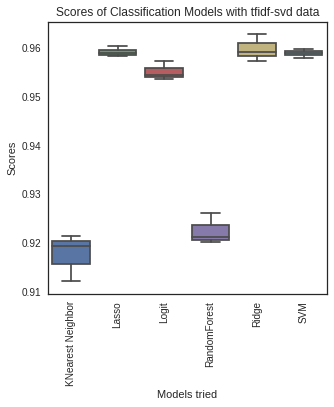

In [0]:
# Plot the results
Scores = {#'Naive Bayes': cvs_RFC_lsa,
          'RandomForest': cvs_RFC_lsa,
          'KNearest Neighbor':cvs_KNN_lsa, 
          'Logit':cvs_Logit_lsa,
          'Lasso':cvs_Lasso_lsa,
          'Ridge':cvs_Ridge_lsa,
          'SVM':cvs_SVM_lsa}
Scoreresults = pd.DataFrame(data=Scores, index=(range(3)))

# Make a boxplot for comparison
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
im = sns.boxplot(data=Scoreresults[Scoreresults.columns], ax=ax)
plt.setp(ax.get_xticklabels(), rotation=90)
im.set_title('Scores of Classification Models with tfidf-svd data')
im.set_ylabel('Scores')
im.set_xlabel('Models tried')

In [0]:
# Plot the results
Scores = {'RandomForest': cvs_RFC_lda,
          'KNearest Neighbor':cvs_KNN_lda, 
          'Logit':cvs_Logit_lda,
          'Lasso':cvs_Lasso_lda,
          'Ridge':cvs_Ridge_lda,
          'SVM':cvs_SVM_lda}
Scoreresults = pd.DataFrame(data=Scores, index=(range(3)))

# Make a boxplot for comparison
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
im = sns.boxplot(data=Scoreresults[Scoreresults.columns], ax=ax)
plt.setp(ax.get_xticklabels(), rotation=90)
im.set_title('Scores of Classification Models with tfidf-latent dirichlet allocation data')
im.set_ylabel('Scores')
im.set_xlabel('Models tried')

In [0]:
# Plot the results
Scores = {#'Naive Bayes': cvs_RFC_lsa,
          'RandomForest': cvs_RFC_nmf,
          'KNearest Neighbor':cvs_KNN_nmf, 
          'Logit':cvs_Logit_nmf,
          'Lasso':cvs_Lasso_nmf,
          'Ridge':cvs_Ridge_nmf,
          'SVM':cvs_SVM_nmf}
Scoreresults = pd.DataFrame(data=Scores, index=(range(3)))

# Make a boxplot for comparison
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
im = sns.boxplot(data=Scoreresults[Scoreresults.columns], ax=ax)
plt.setp(ax.get_xticklabels(), rotation=90)
im.set_title('Scores of Classification Models with tfidf-Non-negative Matrix Factorization data')
im.set_ylabel('Scores')
im.set_xlabel('Models tried')

Best results are obtained with the tfidf-svd data and a logistic regression with Lasso regularization.

## Neural Nets
It seems that the most predictive data is the tfidf data. Therefore, I will use this data as input into a multi-layer perceptron and a convolutional neural net.

In [0]:
import tensorflow as tf
import keras

# Import various componenets for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop

# Import the backend
from keras import backend as K

In [0]:
# Using the whole data 30k tweets for training and 10k tweets as test
# Train data
# Convert the df to arrays
X_train_lsa = lsa_df.iloc[0:10000,:300].values
# healthy=1, unhealthy=0
Y_train_lsa=np.where(Y_train_lsa=='Unhealthy',0,1) 


# Test data
X_test_lsa = test_lsa_df.iloc[0:3000,:300].values
# healthy=1, unhealthy=0
Y_test_lsa=np.where(Y_test_lsa=='Unhealthy',0,1) 

#Normalize the data is not necessary as it comes normalized from the svd
print('X_train max value:',np.amax(X_train_lsa))

# Print sample sizes
print(X_train_lsa.shape[0], 'X train samples')
print(X_test_lsa.shape[0], 'X test samples')

# Print sample sizes
print(Y_train_lsa.shape[0], 'Y train samples')
print(Y_test_lsa.shape[0], 'Y test samples')

X_train max value: 0.8308369710227683
10000 train samples
3000 test samples
10000 train samples
3000 test samples


In [0]:
# Start with a simple sequential model
model = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model.add(Dense(100, activation='relu', input_shape=(300,)))# Input layer = number of features
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(2, activation='softmax'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_5 (Dense)      

In [0]:
history = model.fit(X_train_lsa, Y_train_lsa,
                    batch_size=128,
                    epochs=200,
                    verbose=1,
                    validation_data=(X_test_lsa, Y_test_lsa))
score = model.evaluate(X_test_lsa, Y_test_lsa, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ValueError: ignored

## CNN

In [0]:
import numpy
# input image dimensions, from our data
#img_rows, img_cols = 28, 28
#num_classes = 10

# the data, shuffled and split between train and test sets
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('X_train shape before transformation:',X_train_lsa.shape)

if K.image_data_format() == 'channels_first': # K.image_data_format() Returns the default image data format convention.
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print('Max value before normalization:',np.amax(x_train))
x_train /= 255 # divide by max value
x_test /= 255  # divide by max value of train data
print('Max value after normalization:',np.amax(x_train))
print('X_train shape after transformation:',x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')